# Exploring the Differences Between a Traditional SSP Framework and a Global Warming Levels Approach

Global Warming Levels (GWLs) are an approach for examining regional climate impacts relative to global temperature change. Because modern climate models tend to agree more about **what regional climate impact will look like at each increment of global warming** than about precisely **when that amount of global warming will occur**, using GWLs is a powerful method for combining estimates of future conditions across multiple models and reducing the uncertainty that typically comes from different model estimates of global warming (global climate sensitivity). The GWL approach is used in the <span style="color: blue">[most recent report on global climate change by the Intergovernmental Panel on Climate Change (IPCC AR6)](https://www.ipcc.ch/assessment-report/ar6/)</span>, and the tools in the Analytics Engine follow the methods from that report as closely as possible.

For more general information about using GWLs from climate planning, see the section titled <span style="color: blue">["How should a user choose between Global Warming Levels and a time-based approach to planning?"](https://analytics.cal-adapt.org/guidance/using_in_decision_making/#how-should-a-user-choose-between-global-warming-levels-and-a-time-based-approach-to-planning?)</span> in our guidance material. 

For more in-depth information about the methods for how GWL methods are implemented on the CalAdapt: Analytics Engine, please refer to the information on the 
<span style="color: blue">[Analytics Engine Methods page](https://analytics.cal-adapt.org/analytics/methods/
)</span>.

In this notebook, we will demonstrate the tools that the CalAdapt: Analytics Engine provides to enable climate planning with the Global Warming Level approach.

**Intended Application:** As a user, I want to **<span style="color:#FF0000">learn to work with climate data on Global Warming Levels in the Analytics Engine</span>**, including: 
* Gaining a conceptual understanding of the GWL approach to climate planning
* Understanding the tools that the Analytics Engine and ClimakitAE have for working with data on Global Warming Levels
* Learning how to adapt a target-year based workflow to a GWL workflow, and understand how that may affect my results.


**Intended Application:** As a user, I want to  **<span style="color:#FF0000">understand how to work with climate data using a Global Warming Levels framework, and understand the differences compared to target-year and SSP-based planning.</span>**

**Runtime**: With the default settings, this notebook takes approximately **10 minutes** to run from start to finish. Modifications to selections may increase the runtime.

## 1. Illustration of Global Warming Level Concepts

This section will give a conceptual explaination of the GWL approach, and illustrate some key concepts to understand how it differs from a more traditional target-year planning approach.


In [2]:
from warming_level_approach_helpers import gwl_fig1, gwl_fig2

#### GWL and target-year climatologies

In the figure below, the timeseries of the average global surface temperature it plotted for each of the global climate simulations that were downscaled by LOCA2 and WRF to produce the data used in the Analytics Engine.

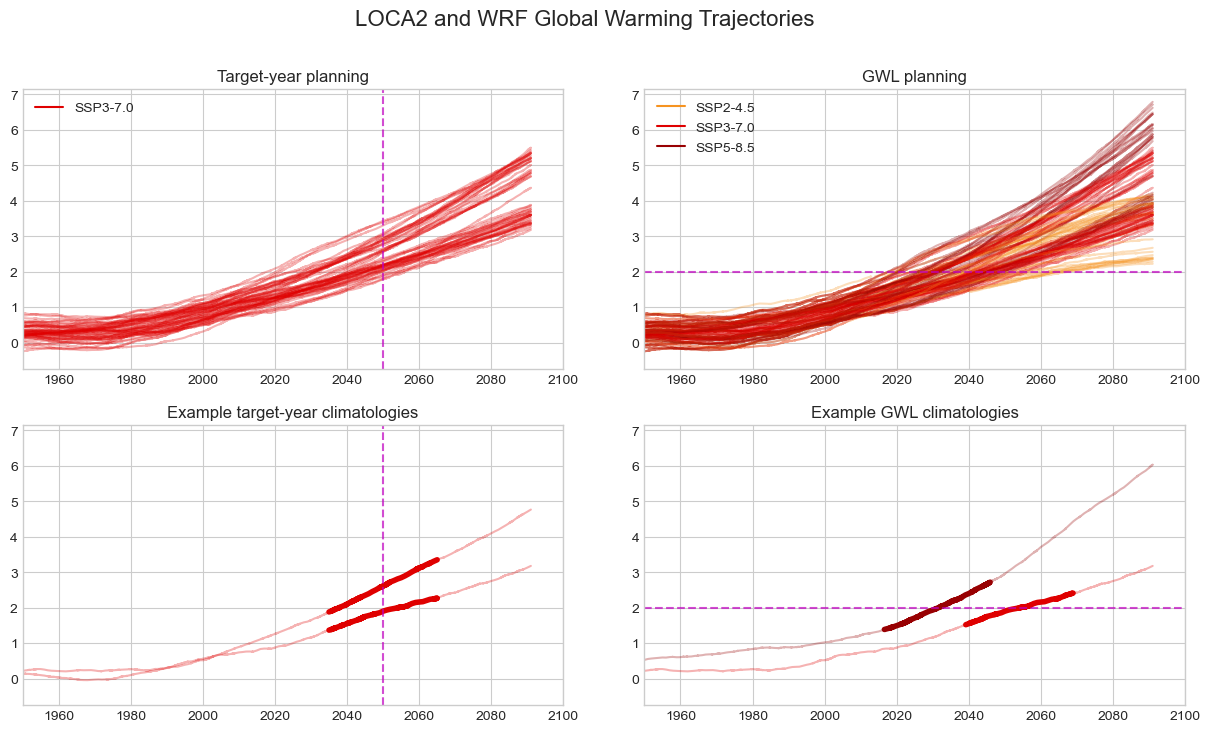

In [3]:
gwl_fig1()

**Target-year planning**

The panels on the **left** represent a target-year based approach to selecting climate data for planning, which asks the question *"What will regional climate impacts look like in the year 2050?"*, and selects data from each climate simulation around the year 2050. 

Only simulations from the same Shared Socioeconomic Pathway (SSP) scenario can be combined, because they share the same assumptions about how quickly warming will occur. The bottom panel illustrates two example 30-year climatologies from different simulations, centered on the year 2050.



**GWL planning**

The panels on the **right** represents a Global Warming Level approach, which asks the question *"What will regional climate impacts be when the world reaches 2.0 °C of global warming?"*, and selects data from each simulation around the time that it crosses 2.0 °C of global warming, regardless of when that happens or what SSP the simulation was running. 

Because regional climate impacts at a given GWL are generally considered to be comparable regardless of when they occur, data from different SSPs can be combined for a GWL approach. This allows more simulations to be utilized, and enables a scenario-agnostic planning approach.

#### GWL timing and avoiding hot model problem

The next figure illustrates how the Global Warming Level approach enables more flexible estimates for the timing of climate change impacts, and avoids uncertainties that would otherwise be introduced by models with high climate sensitivities (sometimes known as the "hot model problem").

Due to a <span style="color: blue">[widely recognized issue in the latest generation of global climate models that caused some of them to warm faster than is considered realistic](https://www.carbonbrief.org/guest-post-how-climate-scientists-should-handle-hot-models/)</span>, the IPCC developed a dataset that draws in additional lines of evidence from observational studies and specialized climate emulators to create a more accurate estimate of the expected warming trajectory for each SSP. Details about the inputs to these likely trajectories are described in the [4th chapter](https://www.ipcc.ch/report/ar6/wg1/chapter/technical-summary/#TS.1.4#cross-section-box-ts.1:-global-surface-temperature-change) of IPCC Sixth Assessment Report (AR6).

The red shaded area in the plot above represents the IPCC's 90% confidence interval for the rate of future global warming under the SSP3-7.0 scenario, with the best estimate warming trajectory shown as the red dashed line.

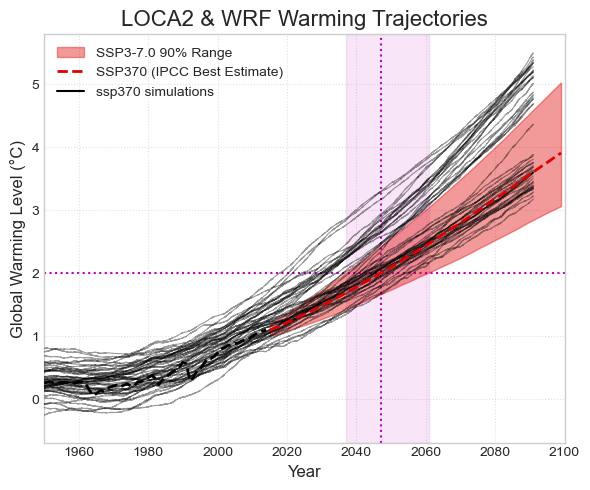

In [4]:
gwl_fig2()

It is apparent that many of the GCM simulations that underly the downscaled LOCA2 and WRF simulations used on the Analytics Engine are warming much faster than the IPCC's best estimates consider's realistic. 

When using a traditional target-year based planning approach, estimates of future impacts will be biased towards a warmer world by these models.

**The GWL approach in the Analytics Engine avoids this bias by breaking the estimation of climate impacts into a two step process:**

1) Aggregate data from all models to estimate the climate impacts at a givel GWL

2) Use the IPCC's refined warming trajectories to estimate *when* that GWL will most likely be reached.


In the example shown in the figure above:  *The 2.0 °C GWL is estimated to be reached between 2037 and 2061 under SSP3-7.0, with the best estimate being 2047*, as indicated by the magenta lines and shaded area.



## 2. Using the Analytics Engine to load climate data on GWLs

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from climakitae.core.data_load import load
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.util.unit_conversions import convert_units

In this notebook, we'll be demonstrating two methods to grab Global Warming Level data from `climakitae`: `get_data` and `ClimateData`. The `ClimateData` method is a newer method that offers some additional flexibility and performance enhancements, but is still actively under development. Both methods are valid for retrieving our climate data. For more information about how both of these methods work, check out <a href="https://github.com/cal-adapt/cae-notebooks/blob/main/data-access/basic_data_access.ipynb" target="_blank" style="color: blue; text-decoration: underline;">this notebook</a>.


**In this notebook, we will be using warming levels 0.8 and 2.0 to compare a historical climate and a future climate respectively.**

We will be grabbing the following data for demonstration purposes:
- Maximum air temperature at 2m
- LOCA2-downscaled
- Monthly time frequency
- 3 km
- Warming Levels: 0.8 and 2.0, with a warming level window of 30 years.

### Method 1: `get_data`

First, we'll go through an example that retrieves data using the `get_data` function. The syntax is nearly identical to loading SSP-based timeseries data, but with the addition of ```approach = "Warming Level"```, and a list of desired warming levels rather than SSP scenarios.

The appropriate data will be pulled for each climate model, using a combination of historical data and future SSP data.

In [6]:
from climakitae.core.data_interface import get_data

gwl_data = get_data(
    variable="Maximum air temperature at 2m",
    resolution="3 km",
    timescale="monthly",
    downscaling_method="Statistical",
    approach="Warming Level",
    warming_level=[0.8, 2.0]
)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.


### Method 2: `ClimateData`

A new method for loading data through climakitae is currently in development. This approach offers more flexibility and faster performance, but is still actively in development and may continue to undergo changes. Here we demonstrate the equivalent data loading operation with the new ClimateData object.

In [7]:
from climakitae.new_core.user_interface import ClimateData
cd = ClimateData()

✅ Ready to query! 


Above, we've created a `ClimateData` object called `cd`, which we will use to grab GWL (Global Warming Level approach) data below.

In [8]:
# Here is an example of loading data at 2 specific warming levels (0.8 and 2.0) with a 15-year window for Max Temp.
gwl_data = (cd
    .catalog("cadcat") 
    .activity_id("LOCA2")   # Statistical downscaling
    .table_id("mon")        # Looking at `monthly` data
    .grid_label("d03")      # Looking at domain 03, which is `3 km` data over California
    .variable("tasmax")     # Grabbing the maximum temperature variable
    .processes({          # Centering our dataset around GWLs
        "warming_level": {
            "warming_levels": [0.8, 2.0], # Standard GWLs include: 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, but any number can be requested
            "warming_level_window": 15, # Default is 15 years on either side of GWL crossing time, for total of 30 years of data
            # "warming_level_months": [6, 7, 8], # Optional: specify months for seasonal averages, still WIP development
        },
    })
    .get()
)

Found 56 datasets matching your query.
Checking processes ...
Querying cadcat catalog with query: {'activity_id': 'LOCA2', 'table_id': 'mon', 'grid_label': 'd03', 'variable_id': 'tasmax'}


INFO: Prepending historical data to SSP scenarios.
      This is the default concatenation strategy for retrieved data in climakitae.
      To change this behavior, set `"concat": "sim"` in your processes dictionary.
Concatenated datasets along 'sim' dimension.
✅ Data retrieval successful!


You'll notice we did not have to specify an SSP to load the data because simulations from any SSP can be used to measure climate impacts at a given GWL. This **ability to utilize data from all SSPs equivalently is one of the benefits of the GWL approach**. 

As you will see below, we receive a data object with up to 129 simulations, which includes data from simulations of SSP 2-4.5, SSP 3-7.0, and SSP 5-8.5

We are also not limited to the parameters listed above. We'll retrieve another set of Global Warming Level data with totally different parameters.

In [9]:
other_gwl_data = (cd
    .catalog("cadcat")    # Same catalog of data as before
    .activity_id("WRF")   # Dynamically-downscaled data
    .table_id("day")      # Daily data
    .grid_label("d02")    # Domain 02, which is 9 km data
    .variable("prec")     # Precipitation data
    .processes({         
        "warming_level": {
            "warming_levels": [1.0, 3.0], # Standard GWLs include: 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, but any number can be requested
            "warming_level_window": 10, # Number of years (+/-) around warming level to retrieve
        },
    })
    .get()
)

Found 19 datasets matching your query.
Checking processes ...
Querying cadcat catalog with query: {'activity_id': 'WRF', 'table_id': 'day', 'grid_label': 'd02', 'variable_id': 'prec'}


INFO: Prepending historical data to SSP scenarios.
      This is the default concatenation strategy for retrieved data in climakitae.
      To change this behavior, set `"concat": "sim"` in your processes dictionary.
Concatenated datasets along 'sim' dimension.
✅ Data retrieval successful!


### What does this data look like?

Let's take a look at the objects and some quick visualizations of the data.

In [10]:
# Looking at the `gwl_data` variable
gwl_data

<xarray.Dataset> Size: 206GB
Dimensions:        (sim: 129, warming_level: 2, time_delta: 360, lat: 495,
                    lon: 559)
Coordinates:
  * sim            (sim) object 1kB 'LOCA2_UCSD_CNRM-ESM2-1_ssp370_mon_d03_r1...
  * warming_level  (warming_level) float64 16B 0.8 2.0
  * lat            (lat) float32 2kB 29.58 29.61 29.64 ... 44.95 44.98 45.02
  * lon            (lon) float32 2kB -128.4 -128.4 -128.4 ... -111.0 -111.0
  * time_delta     (time_delta) int64 3kB -180 -179 -178 -177 ... 177 178 179
    simulation     (sim) <U50 26kB 'LOCA2.UCSD.CNRM-ESM2-1.ssp370.mon.d03.r1i...
    centered_year  (sim, warming_level) int64 2kB 2006 2049 2006 ... 2001 2042
Data variables:
    tasmax         (sim, warming_level, time_delta, lat, lon) float64 206GB dask.array<chunksize=(1, 1, 12, 255, 255), meta=np.ndarray>
Attributes: (12/109)
    CMIP6_CV_version:                    cv=6.2.3.0-7-g2019642
    Conventions:                         CF-1.7 CMIP-6.2
    EXPID:                               CNRM-ESM2-1_historical_r1i1p1f2
    ID_loca_routines_module:             $Id: loca_routines_module.F90,v 1.13...
    SIOCRD_netCDF_Version:               1.0
    SOURCE_loca_routines_module:         $Source: /home6/dwpierc2/src/mine/lo...
    ...                                  ...
    resolution:                          3 km
    warming_level:                       {'warming_levels': [0.8, 2.0], 'warm...
    filter_unadjusted_models:            yes
    concat:                              Process 'concat' applied to the data...
    update_attributes:                   Process 'update_attributes' applied ...
    warming_level_simple:                Process 'warming_level_simple' appli...

**NOTE: One small difference between the `gwl_data` object returned by `ClimateData` and `get_data` is that `ClimateData` will return a xr.Dataset, while `get_data` will return a xr.DataArray. You will just need to dot index (i.e. `gwl_data.tasmax`) into the xr.Dataset to get the DataArray information from above.**

You'll notice that there are two dimensions and one coordinate that are not common in climate data retrieved using an SSP-approach:
1. `warming_level`: This dimension denotes which warming levels the data is centered around, and in this case, we can see the values as 0.8 and 2.0. These are the same as the WLs we chose above.
2. `time_delta`: This dimension represents the offset in timesteps from the `centered_year` of a given simulation. Since each simulation spans 30 years, we can align and stack them along a common `time_delta` axis. Negative values indicate timesteps before the `centered_year`, while positive values indicate timesteps after it.
3. `centered_year`: The year that a given simulation reaches a certain `warming_level`, which can be different for each simulation

### Example: Single model GWL change signal

Now, let's take a quick glance at what this data looks like in a couple of figures:

In [11]:
# select just one simulation for this illustration
gwl_data.isel(sim=0)

<xarray.Dataset> Size: 2GB
Dimensions:        (warming_level: 2, time_delta: 360, lat: 495, lon: 559)
Coordinates:
    sim            <U46 184B 'LOCA2_UCSD_CNRM-ESM2-1_ssp370_mon_d03_r1i1p1f2'
  * warming_level  (warming_level) float64 16B 0.8 2.0
  * lat            (lat) float32 2kB 29.58 29.61 29.64 ... 44.95 44.98 45.02
  * lon            (lon) float32 2kB -128.4 -128.4 -128.4 ... -111.0 -111.0
  * time_delta     (time_delta) int64 3kB -180 -179 -178 -177 ... 177 178 179
    simulation     <U50 200B 'LOCA2.UCSD.CNRM-ESM2-1.ssp370.mon.d03.r1i1p1f2'
    centered_year  (warming_level) int64 16B 2006 2049
Data variables:
    tasmax         (warming_level, time_delta, lat, lon) float64 2GB dask.array<chunksize=(1, 12, 255, 255), meta=np.ndarray>
Attributes: (12/109)
    CMIP6_CV_version:                    cv=6.2.3.0-7-g2019642
    Conventions:                         CF-1.7 CMIP-6.2
    EXPID:                               CNRM-ESM2-1_historical_r1i1p1f2
    ID_loca_routines_module:             $Id: loca_routines_module.F90,v 1.13...
    SIOCRD_netCDF_Version:               1.0
    SOURCE_loca_routines_module:         $Source: /home6/dwpierc2/src/mine/lo...
    ...                                  ...
    resolution:                          3 km
    warming_level:                       {'warming_levels': [0.8, 2.0], 'warm...
    filter_unadjusted_models:            yes
    concat:                              Process 'concat' applied to the data...
    update_attributes:                   Process 'update_attributes' applied ...
    warming_level_simple:                Process 'warming_level_simple' appli...

In [12]:
# Plotting the first timestep of GWL max temp data in a side-by-side plot
from warming_level_approach_helpers import fig1, lighter_r_rev

# Selecting the first simulation, then converting temperature to degF and averaging across the WL data
arr = convert_units(gwl_data.tasmax.isel(sim=0), 'degF').mean(dim='time_delta').compute()

# Finding the difference between WL 2.0 and WL 0.8
diff = arr.sel(warming_level=arr.warming_level.values[-1]) - arr.sel(
    warming_level=arr.warming_level.values[0]
)

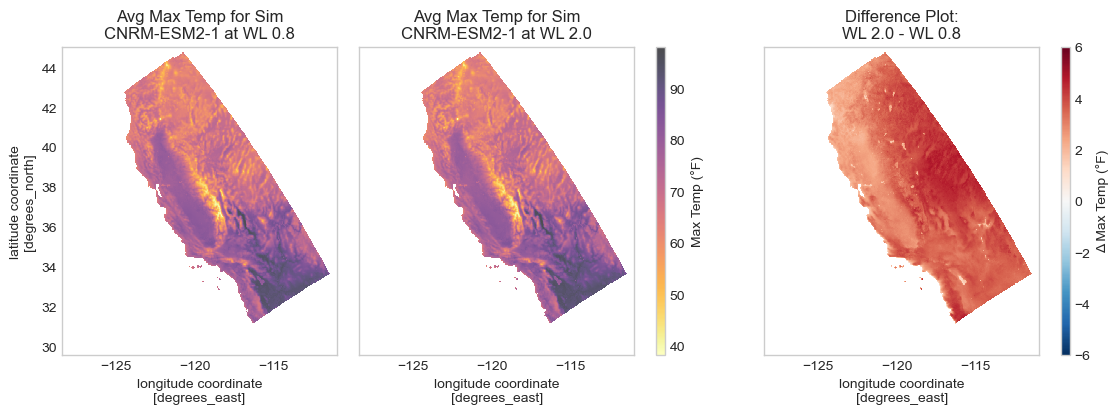

In [13]:
# Using a plotting helper to plot the average warming and a delta plot
fig1(arr, diff)

### Example: Averaged GWL change signal

Below is another example demonstrating how we recommend performing climate change analysis on GWLs. 

In [14]:
# Import precipitation data from WRF

from warming_level_approach_helpers import fig2

gwl_prec_data = (cd
    .catalog("cadcat")    # Same catalog of data as before
    .activity_id("WRF")   # Dynamically-downscaled data
    .table_id("mon")      # Monthly data
    .grid_label("d02")    # Domain 02, which is 9 km data
    .variable("prec")     # Precipitation data
    .processes({         
        "warming_level": {
            "warming_levels": [1.0, 2.0, 3.0], # Standard GWLs include: 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, but any number can be requested
            "warming_level_window": 10, # Number of years (+/-) around warming level to retrieve
        },
    })
    .get()
)

Found 19 datasets matching your query.
Checking processes ...
Querying cadcat catalog with query: {'activity_id': 'WRF', 'table_id': 'mon', 'grid_label': 'd02', 'variable_id': 'prec'}


INFO: Prepending historical data to SSP scenarios.
      This is the default concatenation strategy for retrieved data in climakitae.
      To change this behavior, set `"concat": "sim"` in your processes dictionary.
Concatenated datasets along 'sim' dimension.
✅ Data retrieval successful!


In [15]:

# TAKE THE DIFFERENCE between warming levels before aggregating across simulations.
wl_diff = gwl_prec_data.sel(warming_level=3.0) - gwl_prec_data.sel(warming_level=1.0)

# We average the differences across simulations and time.
avg_diff = wl_diff.mean(dim=['sim', 'time_delta'])

# To understand the range of differences across simulations, we can also compute the max and min difference across simulations
max_diff = wl_diff.mean(dim=['time_delta']).max('sim')
min_diff = wl_diff.mean(dim=['time_delta']).min('sim')

**It's STRONGLY recommended to take the deltas of warming levels before aggregating across simulations**.

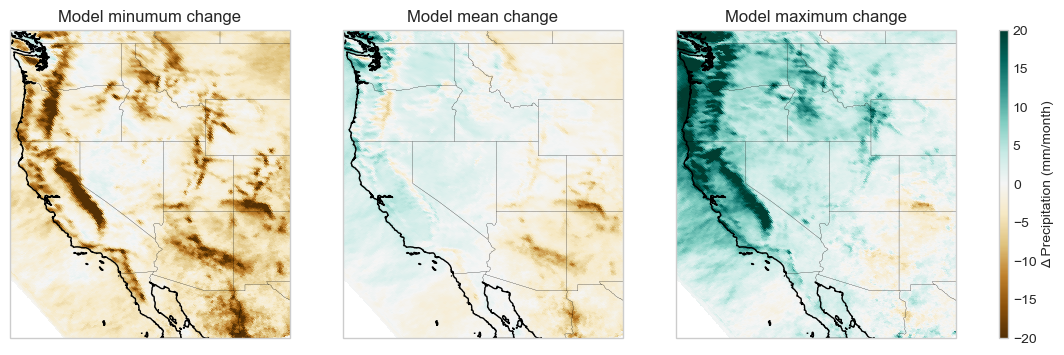

In [16]:
arrs = [min_diff, avg_diff, max_diff]
fig2(arrs)

## 3. Translating between target-year and GWL planning on AE

Now that we've seen the basic process for loading data on GWLs, let's use an example to compare the methods and results of examining climate impacts on GWLs compared to a more traditional target-year approach. 

This example will:
* Demonstrate how the ClimakitAE tools make it simple to switch between loading data on GWLs and a time-based approach
* Walk through how to choose equivalent GWL and time-based planning targets
* Illustrate how GWL planning avoids the influence of the "hot model problem"

### Loading data for GWL planning

In [17]:
# We will again use the 0.8 and 2.0 warming levels for max temp as an example
tasmax_gwl_data = (cd
    .catalog("cadcat")    # Same catalog of data as before
    .activity_id("LOCA2") # Statistically-downscaled data
    .table_id("mon")      # Monthly data
    .grid_label("d03")    # 3 km data
    .variable("tasmax")       # Maximum daily temperature data
    .processes({         
        "warming_level": {
            "warming_levels": [0.8, 2.0], # Available warming levels include: 0.8, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0
            "warming_level_window": 15, # Number of years (+/-) around warming level to retrieve},
        },
    })
    .get()
)

Found 56 datasets matching your query.
Checking processes ...
Querying cadcat catalog with query: {'activity_id': 'LOCA2', 'table_id': 'mon', 'grid_label': 'd03', 'variable_id': 'tasmax'}


INFO: Prepending historical data to SSP scenarios.
      This is the default concatenation strategy for retrieved data in climakitae.
      To change this behavior, set `"concat": "sim"` in your processes dictionary.
Concatenated datasets along 'sim' dimension.
✅ Data retrieval successful!


### Loading data for target-year planning

To properly compare results between a GWL approach and a time-based target year, we need to first determine **what future target-year is equivalent to each GWL**. 

ClimakitAE has tools that are designed to do this:

The `get_year_at_gwl` tool translates GWLs to years using IPCC trajectories. If you're interested in learning more about how these tools work, check out the gwl_timing_tools notebook.

In [18]:
from climakitae.util.warming_levels import get_year_at_gwl

#### **Grabbing SSP-equivalent data of WL 0.8**

In [19]:
# Let's see what year the world would reach 0.8 degrees celsius of warming above pre-industrial levels at different SSP trajectories
get_year_at_gwl(0.8)

,5%,Mean,95%
Historical,1990,2002,2010
SSP 1-1.9,<NA>,<NA>,<NA>
SSP 1-2.6,<NA>,<NA>,<NA>
SSP 2-4.5,<NA>,<NA>,<NA>
SSP 3-7.0,<NA>,<NA>,<NA>
SSP 5-8.5,<NA>,<NA>,<NA>


We'll only be looking at the historical row for WL 0.8, as no simulations reach 0.8 degrees of warming before 2015 (when SSP data begins). 

We'll take a 30-year time slice around the year **2002**.

In [20]:
# Here, we'll use the `ClimateData` object again now to retrieve SSP data.
time_data_08 = (cd
    .catalog("cadcat")
    .activity_id("LOCA2")                    # Statistical downscaling
    .table_id("mon")                         # Looking at `monthly` data
    .grid_label("d03")                       # Looking at `45 km` data
    .variable("tasmax")                          # Grabbing the maximum daily temperature variable (will be used later)
    .experiment_id(["historical", "ssp370"]) # Grabbing historical + SSP 3-7.0 data
    .processes({
        "time_slice": ('1987-01-01', '2016-12-31'), # Only selecting data from 1987 to 2017 (a 30-year slice around the year 2002).
    })
    .get()
)

Found 29 datasets matching your query.
Checking processes ...
Querying cadcat catalog with query: {'activity_id': 'LOCA2', 'experiment_id': ['historical', 'ssp370'], 'table_id': 'mon', 'grid_label': 'd03', 'variable_id': 'tasmax'}


INFO: Prepending historical data to SSP scenarios.
      This is the default concatenation strategy for retrieved data in climakitae.
      To change this behavior, set `"concat": "sim"` in your processes dictionary.
Concatenated datasets along 'sim' dimension.
✅ Data retrieval successful!


#### **Grabbing SSP-equivalent data of WL 2.0**

In [21]:
# Let's see what year the world would reach 2.0 degrees celsius of warming above pre-industrial levels at different SSP trajectories
get_year_at_gwl(2.0, 'all')

,5%,Mean,95%
Historical,<NA>,<NA>,<NA>
SSP 1-1.9,<NA>,<NA>,<NA>
SSP 1-2.6,<NA>,<NA>,<NA>
SSP 2-4.5,2039,2053,2081
SSP 3-7.0,2037,2047,2061
SSP 5-8.5,2034,2042,2054


Let's use SSP 3-7.0 for comparison, and take a 30-year time slice of data around the year **2047** (based on the table above).

In [22]:
# Here, we'll use the `ClimateData` object again now to retrieve SSP data.
time_data_20 = (cd
    .catalog("cadcat")
    .activity_id("LOCA2")                    # Statistical downscaling
    .table_id("mon")                         # Looking at `monthly` data
    .grid_label("d03")                       # Looking at `45 km` data
    .variable("tasmax")                          # Grabbing the maximum daily temperature variable variable (will be used later)
    .experiment_id(["historical", "ssp370"]) # Grabbing historical + SSP 3-7.0 data
    .processes({
        "time_slice": ('2033-01-01', '2062-12-31'), # Only selecting data from 2033 to 2062 (a 30-year slice around the year 2047).
    })
    .get()
)

Found 29 datasets matching your query.
Checking processes ...
Querying cadcat catalog with query: {'activity_id': 'LOCA2', 'experiment_id': ['historical', 'ssp370'], 'table_id': 'mon', 'grid_label': 'd03', 'variable_id': 'tasmax'}


INFO: Prepending historical data to SSP scenarios.
      This is the default concatenation strategy for retrieved data in climakitae.
      To change this behavior, set `"concat": "sim"` in your processes dictionary.
Concatenated datasets along 'sim' dimension.
✅ Data retrieval successful!


### Perform analysis on the data we loaded

For the next two sections, we are going to conduct a comparison of the two datasets by analyzing *changes in temperature during the hottest months of the year.* More specifically, we will try to answer the following question:
<br>
<br>

<h4>&emsp;How much will the temperature of the hottest month of the year in Sacramento increase under climate change by the middle of the century?</h4>

We will conduct a comparison between the 0.8°C and 2.0°C datasets, and do a corresponding time-based component comparison, to further illustrate the differences between a time-based and GWL approach.

In [23]:
# Convert to degF for analysis
tasmax_gwl_data = convert_units(tasmax_gwl_data.tasmax, 'degF')
time_data_08 = convert_units(time_data_08.tasmax, 'degF')
time_data_20 = convert_units(time_data_20.tasmax, 'degF')

In [24]:
# To simplify the analysis for this example, we will choose a single gridcell in Sacramento

lat = 38.617
lon = -121.445

gwl_sac = tasmax_gwl_data.sel(lat=lat, lon=lon, method='nearest')
time_08_sac = time_data_08.sel(lat=lat, lon=lon, method='nearest')
time_20_sac = time_data_20.sel(lat=lat, lon=lon, method='nearest')

Now that our data is clipped, let's analyze both our GWL data and our time-based data.

### GWL-approach analysis

We will be using a function called `add_dummy_time_to_wl`. This function replaces the `time_delta` axis in GWL data with a dummy time axis (starting from 2000), in order to do time-based operations in python.

We will take a look at:
1. The 99th percentile of historical precipitation events.
2. Use that as a threshold for determining the future extreme precipitation events.

In [25]:
data_freq = "monthly"
# Using the `add_dummy_time_to_wl` function so that we can do other time-based operations later.

gwl_sac = add_dummy_time_to_wl(gwl_sac, freq_name=data_freq)
gwl_sac.attrs["frequency"] = data_freq

In [26]:
# to make the following steps faster and easier to iterate on, we will load the data into memory
# This step will take a few minutes to run
# NOTE: this is only recommended once the data has been subset to a small region of interest like in this example

gwl_sac.load()
time_08_sac.load()
time_20_sac.load()

<xarray.DataArray 'tasmax' (sim: 67, time: 360)> Size: 96kB
array([[55.023224, 60.21245 , 70.784424, ..., 82.81984 , 68.51059 ,
        54.79921 ],
       [52.898026, 60.965343, 72.91144 , ..., 85.896286, 72.55817 ,
        57.239716],
       [53.053978, 58.832787, 62.583904, ..., 84.838196, 66.861374,
        62.05123 ],
       ...,
       [61.463905, 65.04265 , 68.63545 , ..., 81.204575, 69.05002 ,
        56.64228 ],
       [58.035072, 59.093273, 65.430954, ..., 84.28827 , 71.29672 ,
        58.588287],
       [56.454742, 60.44223 , 65.30643 , ..., 79.787994, 67.11241 ,
        51.421738]], dtype=float32)
Coordinates:
  * sim      (sim) object 536B 'loca2_ucsd_taiesm1_ssp370_r1i1p1f1' ... 'loca...
    lat      float32 4B 38.61
    lon      float32 4B -121.5
  * time     (time) datetime64[ns] 3kB 2033-01-01 2033-02-01 ... 2062-12-01
Attributes:
    long_name:  tasmax
    units:      degF

In [27]:
# calculate the maximum monthly temperature for each year in the GWL data, then average across years
gwl_sac_temp_mean = gwl_sac.groupby('time.year').max().mean(dim='year')

# now calculate the change signal between 0.8 and 2.0 degC warming levels
gwl_sac_temp_delta = gwl_sac_temp_mean.sel(warming_level=2.0) - gwl_sac_temp_mean.sel(warming_level=0.8)

### Time-based approach analysis

In [28]:
# perform the same calculation for the time-based data
time_08_sac_summer_mean = time_08_sac.groupby('time.year').max().mean(dim='year')
time_20_sac_summer_mean = time_20_sac.groupby('time.year').max().mean(dim='year')
time_20_sac_summer_delta = time_20_sac_summer_mean - time_08_sac_summer_mean


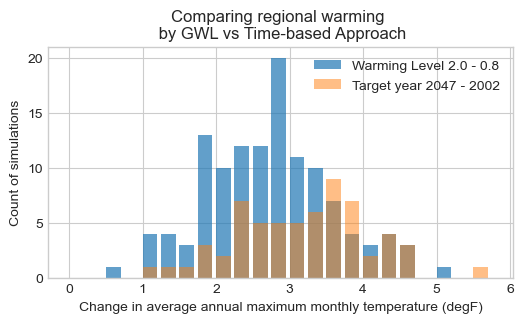

In [ ]:
# Plotting the differences between GWL and target-year planning
plt.figure(figsize=(6, 3))
gwl_sac_temp_delta.plot.hist(width = .2, bins=np.arange(0,6,0.25), alpha=0.7, label = "Warming Level 2.0 - 0.8")
time_20_sac_summer_delta.plot.hist(width = .2, bins=np.arange(0,6,0.25), alpha=0.5, label = "Target year 2047 - 2002")

plt.title('Comparing regional warming \n by GWL vs Time-based Approach')
plt.xlabel('Change in average annual maximum monthly temperature (degF)')
plt.ylabel('Count of simulations')
plt.legend()
plt.show()

In this histogram, each count represents the estimated temperature change signal from one climate simulation.

As we can see from the plot, **the GWL approach is able to include significantly more simulations overall**, because the LOCA2 dataset has simulations at three different SSPs, and the target-year approach can only use one. This larger sample size can be particularly useful when studying extreme conditions and rare events.

**The GWL data also estimates slightly less temperature increase than the equivalent target-year approach**. This is because the target-year method includes estimates from the "hot models", while the GWL approach adjusts for these by using the IPCC's estimated warming trajectories.

Overall, the tools in the Analytics Engine are designed to make transitioning between analysis on GWLs and time-based target-year analysis as simple as possible, by sharing the same data structure and analysis tools.

**If you're interested in learning more about use-cases when you'd want to use a Global Warming Level approach over a time-based approach, check out our guidance <a href="https://analytics.cal-adapt.org/guidance/using_in_decision_making/#how-should-a-user-choose-between-global-warming-levels-and-a-time-based-approach-to-planning" target="_blank" style="color: blue; text-decoration: underline;">here</a> for more details.**